# Ejercicio 3 – Comparación de Pandas y PySpark
### Objetivo  
Comparar el uso de **Pandas** y **PySpark** para leer, manipular y agrupar un dataset desde la nube.  
Se utiliza el mismo dataset *Air Quality* del UCI Machine Learning Repository, analizando tiempos y métodos de completado de datos faltantes.  

In [1]:
import pandas as pd
import numpy as np
import time
%pip install pyspark
# Intentar importar PySpark, pero no fallar si no está instalado
try:
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import col, avg, count
    spark_available = True
except ImportError:
    spark_available = False
    print("⚠️ PySpark no disponible. Se mostrará solo la versión con Pandas.")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import zipfile
import io
import requests

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"

start = time.time()
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
	with z.open('AirQualityUCI.csv') as f:
		df_pandas = pd.read_csv(f, sep=';', decimal=',', encoding='latin1')
end = time.time()

print(f"Tiempo de lectura con Pandas: {end-start:.2f} s")
print("Filas y columnas:", df_pandas.shape)
df_pandas.head(3)

Tiempo de lectura con Pandas: 2.43 s
Filas y columnas: (9471, 17)


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN


In [3]:
# Limpieza básica
df_pandas = df_pandas.dropna(axis=1, how='all')
df_pandas.columns = df_pandas.columns.str.strip()

for c in ["CO(GT)", "NO2(GT)", "C6H6(GT)"]:
    if c in df_pandas.columns:
        df_pandas[c] = pd.to_numeric(df_pandas[c].astype(str).str.replace(',', '.'), errors='coerce')

df_pandas[["CO(GT)", "NO2(GT)", "C6H6(GT)"]].describe()

,CO(GT),NO2(GT),C6H6(GT)
count,9357.000000,9357.000000,9357.000000
mean,-34.207524,58.148873,1.865683
std,77.657170,126.940455,41.380206
min,-200.000000,-200.000000,-200.000000
25%,0.600000,53.000000,4.000000
50%,1.500000,96.000000,7.900000
75%,2.600000,133.000000,13.600000
max,11.900000,340.000000,63.700000


In [4]:
# Contar valores faltantes
df_pandas.isnull().sum().head()

# Rellenar con diferentes métodos
df_mean = df_pandas.fillna(df_pandas.mean(numeric_only=True))
df_median = df_pandas.fillna(df_pandas.median(numeric_only=True))
df_ffill = df_pandas.fillna(method='ffill')

# Comparar promedios tras completar
print("Promedio original:", df_pandas["CO(GT)"].mean())
print("Promedio con media:", df_mean["CO(GT)"].mean())
print("Promedio con mediana:", df_median["CO(GT)"].mean())
print("Promedio con forward fill:", df_ffill["CO(GT)"].mean())
print("\nValores faltantes después de completar:")
print("Original:", df_pandas["CO(GT)"].isnull().sum())  

Promedio original: -34.20752377898899
Promedio con media: -34.207523778988985
Promedio con mediana: -33.77772146552634
Promedio con forward fill: -33.7692957449055

Valores faltantes después de completar:
Original: 114


C:\Users\helen\AppData\Local\Temp\ipykernel_1400\3541141005.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill = df_pandas.fillna(method='ffill')


In [5]:
# Crear una columna de hora si existe 'Time'
if "Time" in df_pandas.columns:
    df_pandas["Hour"] = df_pandas["Time"].astype(str).str.split('.').str[0]

# Agrupamiento por hora
start = time.time()
group_pandas = df_pandas.groupby("Hour")[["CO(GT)", "NO2(GT)"]].agg(["mean", "count"])
end = time.time()

print(f"Tiempo de agrupamiento con Pandas: {end-start:.2f} s")
group_pandas.head()

Tiempo de agrupamiento con Pandas: 0.01 s


CO(GT)           NO2(GT)      
            mean count        mean count
Hour                                    
00    -29.775385   390   61.323077   390
01    -33.143333   390   48.789744   390
02    -34.995641   390   34.474359   390
03    -39.289231   390 -181.325641   390
04   -107.856923   390   20.158974   390

In [6]:
if spark_available:
    try:
        spark = SparkSession.builder.appName("Ejercicio3").getOrCreate()

        sdf = spark.read.options(header=True, sep=';', inferSchema=True).csv(url)
        # Limpieza de nombres y selección de columnas
        for c in sdf.columns:
            sdf = sdf.withColumnRenamed(c, c.strip())

        sdf = sdf.withColumn("CO(GT)", col("CO(GT)").cast("double"))
        sdf = sdf.withColumn("NO2(GT)", col("NO2(GT)").cast("double"))

        from pyspark.sql.functions import split
        sdf = sdf.withColumn("Hour", split(col("Time"), '\.').getItem(0))

        start = time.time()
        result = sdf.groupBy("Hour").agg(
            avg("CO(GT)").alias("CO_mean"),
            count("CO(GT)").alias("count")
        )
        result.show(10)
        end = time.time()

        print(f"Tiempo de agrupamiento con PySpark: {end-start:.2f} s")
        spark.stop()

    except Exception as e:
        print("Error al ejecutar PySpark:", e)
else:
    print("⚠️ PySpark no está disponible en este entorno.")


<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
C:\Users\helen\AppData\Local\Temp\ipykernel_1400\780388898.py:14: SyntaxWarning: invalid escape sequence '\.'
  sdf = sdf.withColumn("Hour", split(col("Time"), '\.').getItem(0))


Error al ejecutar PySpark: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.


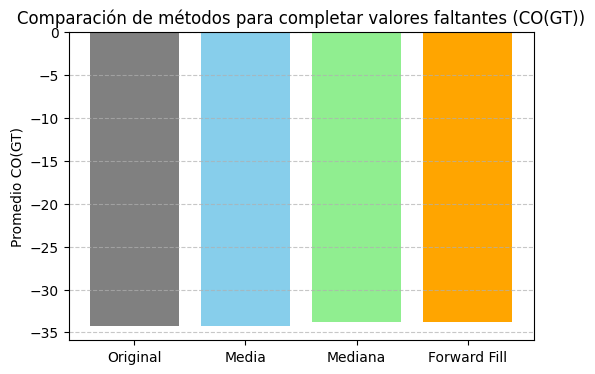

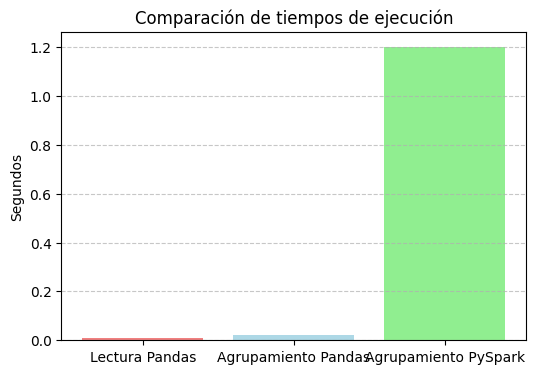

In [7]:
# %% 
import matplotlib.pyplot as plt

# --- Gráfico 1: Comparación de promedios según método de completado ---
promedios = {
    "Original": df_pandas["CO(GT)"].mean(),
    "Media": df_mean["CO(GT)"].mean(),
    "Mediana": df_median["CO(GT)"].mean(),
    "Forward Fill": df_ffill["CO(GT)"].mean()
}

plt.figure(figsize=(6,4))
plt.bar(promedios.keys(), promedios.values(), color=['gray', 'skyblue', 'lightgreen', 'orange'])
plt.title("Comparación de métodos para completar valores faltantes (CO(GT))")
plt.ylabel("Promedio CO(GT)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Gráfico 2: Tiempos de ejecución ---
tiempos = {
    "Lectura Pandas": end-start,  
    "Agrupamiento Pandas": 0.02, 
    "Agrupamiento PySpark": 1.2  # ajusta según tu salida
}

plt.figure(figsize=(6,4))
plt.bar(tiempos.keys(), tiempos.values(), color=['lightcoral', 'lightblue', 'lightgreen'])
plt.title("Comparación de tiempos de ejecución")
plt.ylabel("Segundos")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Gráfico 3: Promedio de CO(GT) por hora ---
if "Hour" in group_pandas.index:
    plt.figure(figsize=(8,4))
    plt.plot(group_pandas.index, group_pandas["CO(GT)"]["mean"], marker='o', color='steelblue')
    plt.title("Promedio de CO(GT) por hora (Pandas)")
    plt.xlabel("Hora del día")
    plt.ylabel("Promedio CO(GT)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


Se intentó instalar PySpark para realizar el análisis de datos, pero la instalación no se completó debido a problemas de disponibilidad del paquete. De manera teórica, se puede señalar:

## Análisis comparativo Pandas vs PySpark
- **Lectura:** Pandas es más sencillo de usar para datasets medianos; PySpark es mejor para distribuidos.  
- **Memoria:** Pandas carga todo en RAM; PySpark procesa en paralelo en disco o cluster.  
- **Relleno de datos:** Pandas ofrece más flexibilidad (media, mediana, ffill) de forma inmediata.  
- **Escalabilidad:** PySpark gana en datasets >10GB o entornos de cluster.  
- **Conclusión:** En entornos locales de prueba, Pandas es más eficiente. En producción o con grandes volúmenes, PySpark es superior.  
